## 시간표 수정
- 9:00 ~ 9:35 1교시
- 9:45 ~ 10:20 2교시
- 10:30 ~

In [1]:
%matplotlib inline


2-3_Transfer Learning for Computer Vision Tutorial
==============================================
In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning.

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.




In [3]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2025-02-07 00:04:51--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.65.3.37, 18.65.3.71, 18.65.3.38, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.65.3.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   240MB/s    in 0.2s    

2025-02-07 00:04:51 (240 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        # build your own transforms
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



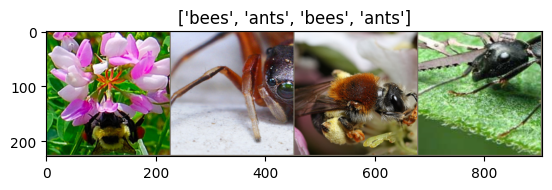

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
print(inputs.shape)

print(out.shape)

torch.Size([4, 3, 224, 224])
torch.Size([3, 228, 906])


Training the model
------------------

Now, let's write a general function to train a model.


In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.cuda()
                labels = labels.cuda()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, target: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.
- torchvision.models ([documentation](https://pytorch.org/vision/0.9/models.html))




In [9]:
model_ft = models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


In [10]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
model_ft.fc

Linear(in_features=512, out_features=1000, bias=True)

In [12]:
model_ft.fc.out_features

1000

### Practice: 사전 학습된 ResNet18 모델의 FC layer를 재학습 시켜보도록 하겠습니다.
1. ResNet18.fc layer 초기화
2. Learning rate scheduler 정의 ([참고](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR))

In [13]:
# 1. replace the fc layer with output sample size 2
model_ft.fc = nn.Linear(512, 2)

model_ft = model_ft.cuda()
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 2. Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Practice: 학습 가능한 파라미터 수 확인하기

In [15]:
# torch.numel (https://pytorch.org/docs/stable/generated/torch.numel.html)

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_trainable_params(model_ft)}")

Trainable parameters: 11177538


In [18]:
# explore model.state_dict()

def count_trainable_params(model):
    return sum(p.numel() for k, p in model_ft.state_dict().items() if ("weight" in k or "bias" in k))

print(f"Trainable Parameters: {count_trainable_params(model_ft)}")

Trainable Parameters: 11177538


In [20]:
from torch.nn.utils import parameters_to_vector
# parameters_to_vector (https://pytorch.org/docs/stable/generated/torch.nn.utils.parameters_to_vector.html)

def count_trainable_params(model):
    return parameters_to_vector(model.parameters()).numel()

print(f"Trainable Parameters: {count_trainable_params(model_ft)}")

Trainable Parameters: 11177538


In [14]:
!pip install torchinfo

In [21]:
from torchinfo import summary

summary(model_ft, input_size=[4, 3, 224, 224])  # 입력 크기 지정

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [4, 2]                    --
├─Conv2d: 1-1                            [4, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [4, 64, 112, 112]         128
├─ReLU: 1-3                              [4, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [4, 64, 56, 56]           --
├─Sequential: 1-5                        [4, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [4, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [4, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [4, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [4, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [4, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [4, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [4, 64, 56, 56]           --
│

### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [22]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)

Epoch 0/1
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.5713 Acc: 0.7131
val Loss: 0.4463 Acc: 0.8170

Epoch 1/1
----------
train Loss: 0.5458 Acc: 0.7828
val Loss: 0.4303 Acc: 0.8889

Training complete in 0m 6s


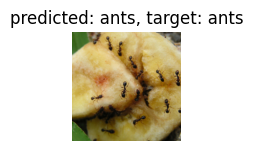

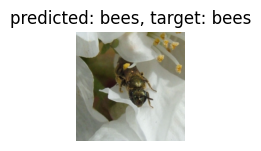

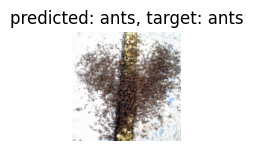

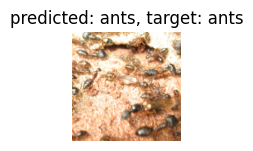

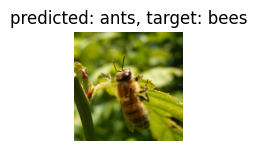

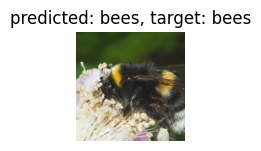

In [23]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.




In [24]:
model_conv = models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())
print("Number of parameters: ", count_parameters(model_conv))

Number of parameters:  11689512


In [26]:
# 1. freeze all the parameters of the pretrained network
for p in model_conv.parameters():
    p.requires_grad = False

# 2. replace the pretrained fully connected layer `model_conv.fc` with a new one
model_conv.fc = nn.Linear(512, 2)

model_conv = model_conv.cuda()
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [28]:
# torch.numel (https://pytorch.org/docs/stable/generated/torch.numel.html)

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_trainable_params(model_conv)}")

Trainable parameters: 1026


In [29]:
model_conv

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
model_conv.conv1.weight.requires_grad

False

In [31]:
model_conv.fc.weight.requires_grad

True

In [32]:
model_conv.fc.weight.data = torch.zeros_like(model_conv.fc.weight.data)
model_conv.fc.bias.data = torch.ones_like(model_conv.fc.bias.data)

In [33]:
model_conv.fc.weight.data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [34]:
summary(model_conv, input_size=(4, 3, 224, 224))  # 입력 크기 지정

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [4, 2]                    --
├─Conv2d: 1-1                            [4, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [4, 64, 112, 112]         (128)
├─ReLU: 1-3                              [4, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [4, 64, 56, 56]           --
├─Sequential: 1-5                        [4, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [4, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [4, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-2             [4, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [4, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [4, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [4, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [4, 64, 56, 56]   

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [35]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=2)

Epoch 0/1
----------
train Loss: 0.5816 Acc: 0.7008
val Loss: 0.2079 Acc: 0.9281

Epoch 1/1
----------
train Loss: 0.5058 Acc: 0.7705
val Loss: 0.1896 Acc: 0.9216

Training complete in 0m 6s


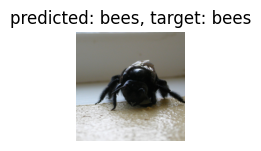

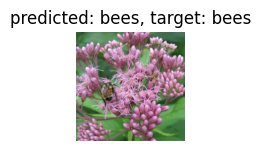

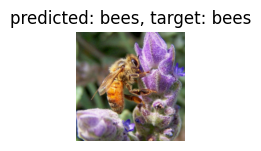

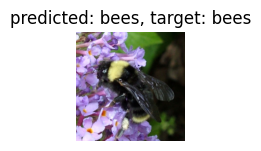

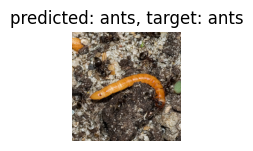

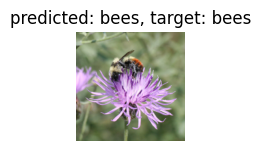

In [36]:
visualize_model(model_conv)

plt.ioff()
plt.show()

### VGG16

Load a VGG16 (both pretrained=False and True)!




In [37]:
model_vgg = models.vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 81.5MB/s]


In [38]:
model_vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
for param in model_vgg.parameters():
    param.requires_grad = False

model_vgg.classifier = nn.Linear(25088, 2)

model_vgg = model_vgg.cuda()
criterion = nn.CrossEntropyLoss()

optimizer_vgg = optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_vgg, step_size=7, gamma=0.1)

In [ ]:
model_vgg = train_model(model_vgg, criterion, optimizer_vgg, exp_lr_scheduler, num_epochs=25)

In [ ]:
model_vgg = models.vgg16(pretrained=False)

In [ ]:
model_vgg.classifier = nn.Linear(25088, 2)

model_vgg = model_vgg.cuda()
criterion = nn.CrossEntropyLoss()

optimizer_vgg = optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_vgg, step_size=7, gamma=0.1)

In [ ]:
model_vgg = train_model(model_vgg, criterion, optimizer_vgg, exp_lr_scheduler, num_epochs=25)

### Visualize feature map

VGG16 커널 시각화 실습

[Feature Visualization](https://distill.pub/2017/feature-visualization/) from Google

[Microscope](https://microscope.openai.com/models) from OpenAI

### Prerequisite

Feature visualization on a well-trained classifier

![](https://miro.medium.com/v2/resize:fit:1400/1*bIY_8FE7dJaGk1kjU7iVSg.png)

A neuron in a specific layer in a well-trained classifier becomes a feature detector. Why?

![](https://christophm.github.io/interpretable-ml-book/images/cnn-features.png)

A visualization on a feature on which a neuron fires

![](https://media.wired.co.uk/photos/606da9aae46630a583ab297f/16:9/w_2560%2Cc_limit/googledream1.jpg)

In [ ]:
# cat.jpg 다운로드
!wget -O cat.jpg https://raw.githubusercontent.com/ozmig77/lecture_files/main/cat.jpg

# dog.jpg 다운로드
!wget -O dog.jpg https://www.princeton.edu/sites/default/files/styles/half_1x_crop/public/images/2022/02/KOA_Nassau_2697x1517.jpg?itok=JIi_KPMe

In [ ]:
vgg16 = models.vgg16(pretrained=True).features
vgg16.eval()

### VGG16 Feature Map 시각화

In [ ]:
from PIL import Image

def visualize_feature_maps(model, image, layer_idx):
    """
    model: VGG16 Feature Extractor
    image: (1, 3, 224, 224) 형태의 입력 이미지
    layer_idx: 출력하고 싶은 Conv 레이어 인덱스
    """
    feature_maps = None

    # Hook을 이용하여 중간 feature map 저장
    def hook_fn(module, input, output):
        nonlocal feature_maps
        feature_maps = output

    hook = model[layer_idx].register_forward_hook(hook_fn)
    model(image)  # Forward pass
    hook.remove()  # Hook 제거

    # 1. 특징 맵 변환 (차원: (batch, channels, height, width) → (channels, height, width))
    ...

    # 2. 특징 맵 상위 10 채널 추출
    ...

    fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))

    for i in range(num_channels):
        axes[i].imshow(feature_maps[i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Channel {i+1}')
    plt.suptitle(f"Feature Maps from Layer Index: {layer_idx}", fontsize=14, fontweight="bold")
    plt.show()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # 배치 차원 추가
    return image


In [ ]:
image_path = "cat.jpg"
input_image = load_image(image_path)

for i in range(15):
  visualize_feature_maps(vgg16, input_image, layer_idx=i)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
image_path = "dog.jpg"
input_image = load_image(image_path)

for i in range(15):
  visualize_feature_maps(vgg16, input_image, layer_idx=i)

### VGG16 필터(커널) 시각화

필터(커널)를 시각화하는 방법입니다. 1번째 Conv2d 계층의 필터를 시각화해 보겠습니다.

In [ ]:
import torchvision.utils as vutils

# 1. 첫 번째 Conv2d 계층 필터 가져오기
...

# 2. 필터 정규화 (0~1)
min_val, max_val = conv1_weights.min(), conv1_weights.max()
conv1_weights = ...

# 3. 첫 6개의 필터 출력
...

fig, axes = plt.subplots(1, num_kernels, figsize=(15, 5))

for i in range(num_kernels):
    kernel = conv1_weights[i].permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
    axes[i].imshow(kernel)
    axes[i].axis('off')
    axes[i].set_title(f'Filter {i+1}')

plt.show()

In [ ]:
import torchvision.utils as vutils

conv1_weights = vgg16[10].weight.data.cpu()

min_val, max_val = conv1_weights.min(), conv1_weights.max()
conv1_weights = (conv1_weights - min_val) / (max_val - min_val)

num_kernels = min(6, conv1_weights.shape[0])
fig, axes = plt.subplots(1, num_kernels, figsize=(15, 5))

for i in range(num_kernels):
    kernel = conv1_weights[i].permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
    kernel = kernel.sum(-1)
    axes[i].imshow(kernel, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Filter {i+1}')

plt.show()